<a href="https://colab.research.google.com/github/vamado09/Applied-Data-Science/blob/main/Week4_VicenteDeLeon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Vicente De Leon

IU_id: 2001014594

APPLIED DATA SCIENCE: 9998

# Part 1 - Linear Regression

In [61]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from pandas.tseries.holiday import USFederalHolidayCalendar
from sklearn.utils import resample
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')


**Linear Regression**

It's used to basically model the relationship between two variables: X(indepdent variable) and Y (dependent variable). The goal here is to find a straight line that best fits the data points, showing the trends of how Y changes with X.


$$y = ax + b$$

- y: predicted value
- a: slope
- b: intercept
- x: predictor

Slope:

- If the slope is negative, y decreases as x increases and the function runs downhill.
- If the slope is zero, y does not change, thus is constant—a horizontal line.

**Pricing vs Sales**

For example, pricing (X) vs sales (Y). I want to understand/see how the price of a product impact sales, my independent variable is price (X) and my dependent variable would be sales (Y).

- Negative slope (downhill): it means price increases and sales decreases.
- Positive slope (uphill): price increases and sales also increase

Obviously, for a much more comprehensive analysis, I'm sure I will need more features rather than just product_id, price, and sales.

I've always being very good at creating classification algorithms using logistic regression, SVMs, and neural networks, but I've never made emphasis in linear regression models. Now at work, this is something I plan to tackle. Maybe my final project could be a draft implementation of the things I plan to do at work in the future. Although, non linear models could be more beneficial in pricing.. (more research has to be done).

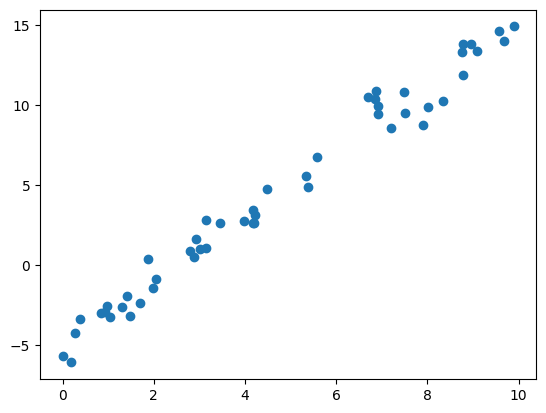

In [3]:
rng = np.random.RandomState(1)
x = 10 * rng.rand(50)
y = 2 * x - 5 + rng.randn(50)
plt.scatter(x, y);

We can use Scikit-Learn's LinearRegression estimator to fit this data and construct the best-fit line as shown below:

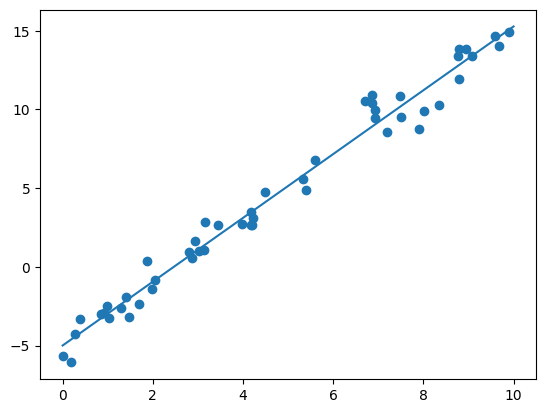

In [5]:
model = LinearRegression(fit_intercept = True)

model.fit(x[:, np.newaxis], y)

xfit = np.linspace(0, 10, 1000)
yfit = model.predict(xfit[:, np.newaxis])

plt.scatter(x, y)
plt.plot(xfit, yfit);

The slope and intercept of the data are contained in the model's fit parameters, which in Scikit-Learn are always marked by a trailing underscore.

In [6]:
print('Model slope: ', model.coef_[0])
print('Model intercept: ', model.intercept_)

Model slope:  2.0272088103606953
Model intercept:  -4.998577085553204


In pricing, the intercept could help the model fit my data better so it can improve accuracy and make better price recommendations. But I think in my case, I should focus on slope (for now).

**Multidimensional linear model**

Where there are multiple x values. Geometrically, this is akin to fitting a plane to points in three dimensions, or fitting a hyper-plane to points in higher dimensions.

The multidimensional nature of such regressions makes them more difficult to visualize, but we can see one of these fits in action by building some example data, using NumPy's matrix multiplication operator:

In [7]:
rng = np.random.RandomState(1)
X = 10 * rng.rand(100, 3)
y = 0.5 + np.dot(X, [1.5, -2., 1.])

model.fit(X, y)
print(model.intercept_)
print(model.coef_)

0.5000000000000033
[ 1.5 -2.   1. ]


Here the y data is constructed from three random x values, and the linear regression recovers the coefficients used to construct the data.

In this way, we can use the single LinearRegression estimator to fit lines, planes, or hyperplanes to our data. It still appears that this approach would be limited to strictly linear relationships between variables, but it turns out we can relax this as well.

## Basis Function Regression

One trick we can use to adapt linear regression to nonlinear relationships between variables is to transform the data according to basis functions.

### Polynomial Basis Function

In [9]:
x = np.array([2, 3, 4])
poly = PolynomialFeatures(3, include_bias = False)
poly.fit_transform(x[:, None])

array([[ 2.,  4.,  8.],
       [ 3.,  9., 27.],
       [ 4., 16., 64.]])

We can see here that the transformer has converted our one dimensional array into a three dimensional array by taking the exponent of each value.

This new, higher-dimensional data representation can then be plugged into a linear regression. I agree with the author, the cleanest way we could this is by using a pipeline. This is something I did a lot back when I took Applied Machine Learning with Professor Shanahan.

As you noted in the module, within my pipelines I used to incoporate preprocessing (Normalization and standardization for example) as well. Sometimes we forget how good pipelines are for our preprocessing and feature engineering process.



In [11]:
poly_model = make_pipeline(PolynomialFeatures(7),
                           LinearRegression())

In [12]:
poly_model

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=7)),
                ('linearregression', LinearRegression())])

Now, we can use the linear model to fit much more complicated relationships between x and y:

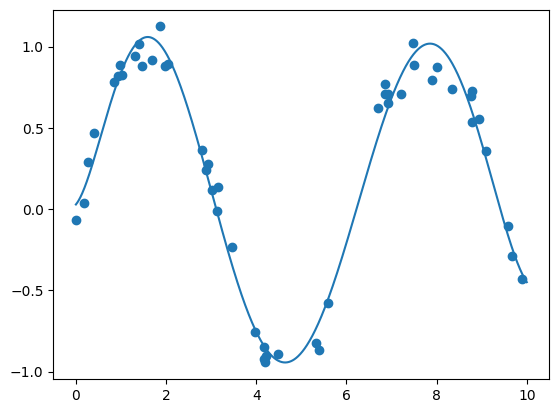

In [13]:
rng = np.random.RandomState(1)
x = 10 * rng.rand(50)
y = np.sin(x) + 0.1 * rng.randn(50)

poly_model.fit(x[:, np.newaxis], y)
yfit = poly_model.predict(xfit[:, np.newaxis])

plt.scatter(x, y)
plt.plot(xfit, yfit);

### Gaussian Basis Function

One useful pattern is to fit a model that is not a sum of polynomial bases, but a sum of Gaussian bases. The result might look something like these:

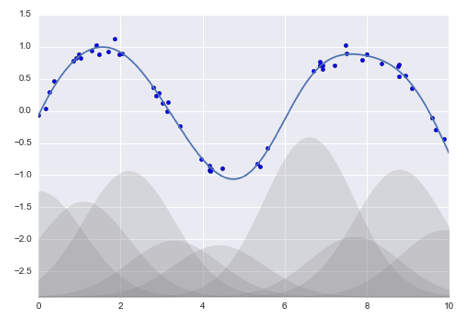

The shaded regions in the plot are the scaled basis functions, and when added together they reproduce the smooth curve through the data. IMPORTANT: These Gaussian basis functions are not built into Scikit-Learn.

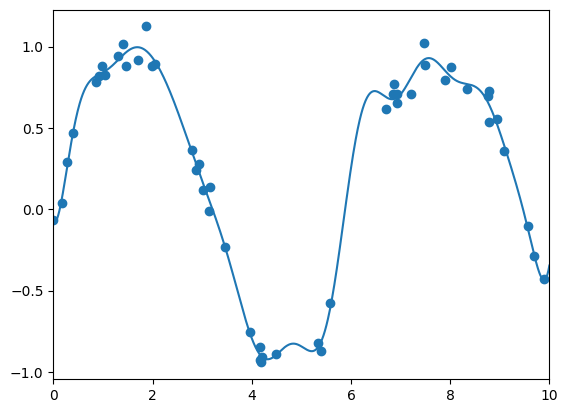

In [14]:
from sklearn.base import BaseEstimator, TransformerMixin

# Uniformly spaced Gaussian features for one-dimensional input
class GaussianFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, N, width_factor=2.0):
        self.N = N
        self.width_factor = width_factor

    @staticmethod
    def _gauss_basis(x, y, width, axis=None):
        arg = (x - y) / width
        return np.exp(-0.5 * np.sum(arg ** 2, axis))

    def fit(self, X, y=None):
        # create N centers spread along the data range
        self.centers_ = np.linspace(X.min(), X.max(), self.N)
        self.width_ = self.width_factor * (self.centers_[1] - self.centers_[0])
        return self

    def transform(self, X):
        return self._gauss_basis(X[:, :, np.newaxis], self.centers_,
                                 self.width_, axis=1)

gauss_model = make_pipeline(GaussianFeatures(20),
                            LinearRegression())
gauss_model.fit(x[:, np.newaxis], y)
yfit = gauss_model.predict(xfit[:, np.newaxis])

plt.scatter(x, y)
plt.plot(xfit, yfit)
plt.xlim(0, 10);

## Regularization

Ridge and lasso regression are effective methods in machine learning, that introduce penalties on the magnitude of regression coefficients. However, their approaches and suitability differ depending on the specific data analysis problem.

This is very important -> avoiding overfitting and underfitting.

The introduction of basis functions into the linear regression makes the model much more flexible, but it also can very quickly lead to overfitting. For example, if we choose too many Gaussian basis functions, we end up with results that don't look so good:

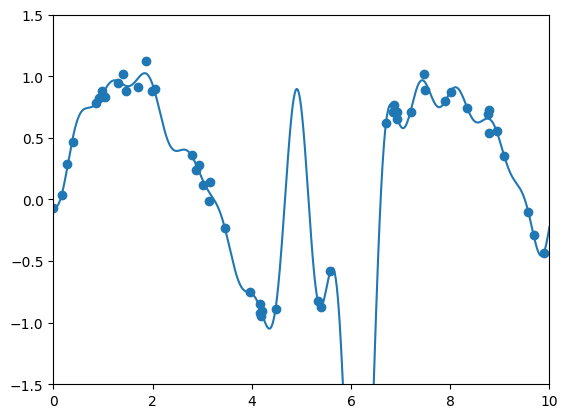

In [16]:
model = make_pipeline(GaussianFeatures(30),
                      LinearRegression())
model.fit(x[:, np.newaxis], y)

plt.scatter(x, y)
plt.plot(xfit, model.predict(xfit[:, np.newaxis]))

plt.xlim(0, 10)
plt.ylim(-1.5, 1.5);

With the data projected to the 30-dimensional basis, the model has far too much flexibility and goes to extreme values between locations where it is constrained by data. We can see the reason for this if we plot the coefficients of the Gaussian bases with respect to their locations:

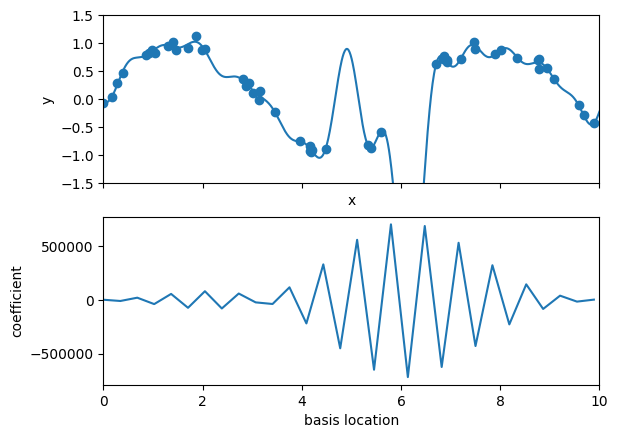

In [17]:
def basis_plot(model, title=None):
    fig, ax = plt.subplots(2, sharex=True)
    model.fit(x[:, np.newaxis], y)
    ax[0].scatter(x, y)
    ax[0].plot(xfit, model.predict(xfit[:, np.newaxis]))
    ax[0].set(xlabel='x', ylabel='y', ylim=(-1.5, 1.5))

    if title:
        ax[0].set_title(title)

    ax[1].plot(model.steps[0][1].centers_,
               model.steps[1][1].coef_)
    ax[1].set(xlabel='basis location',
              ylabel='coefficient',
              xlim=(0, 10))

model = make_pipeline(GaussianFeatures(30), LinearRegression())
basis_plot(model)

The lower panel of this figure shows the amplitude of the basis function at each location. This is typical over-fitting behavior when basis functions overlap: the coefficients of adjacent basis functions blow up and cancel each other out. We know that such behavior is problematic, and it would be nice if we could limit such spikes expliticly in the model by penalizing large values of the model parameters. Such a penalty is known as regularization, and comes in several forms.

### My experience - Overfitting/Underfitting

I used to apply regularization techniques (which I need to practice)to my ML models (accuracy behaviour) and neural networks (loss behaviour) to avoid this kind of stuff. I think that one of the best ways to asses this behaviour is by applying some sort of visualization into your model performance using matplotlib/seaborn, tensforboard etc to see what's going on.

The Geeks for Geeks sources I have in sources is a good reference to understand this. I always go back to those notes!

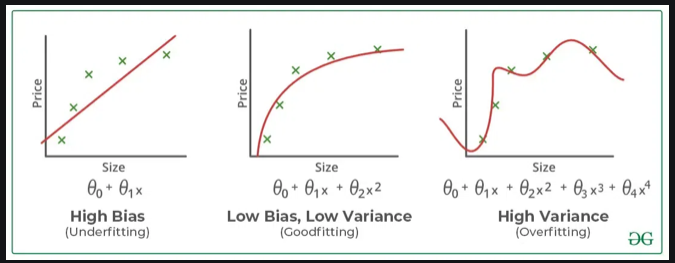

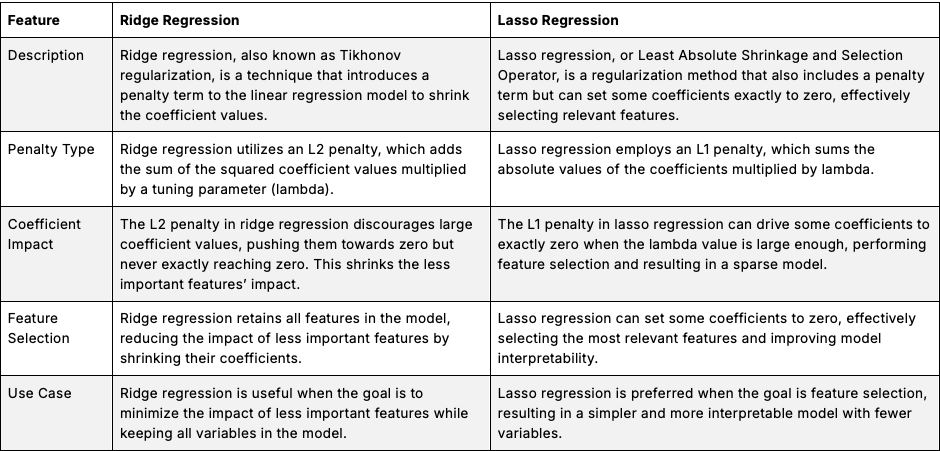

### Ridge Regression

Perhaps the most common form of regularization is known as ridge regression or L2 regularization, sometimes also called Tikhonov regularization.

$$ P = \alpha \sum_{n=1}^{N} \theta_n^2 $$

where α is a free parameter that controls the strength of the penalty. This type of penalized model is built into Scikit-Learn with the Ridge estimator.

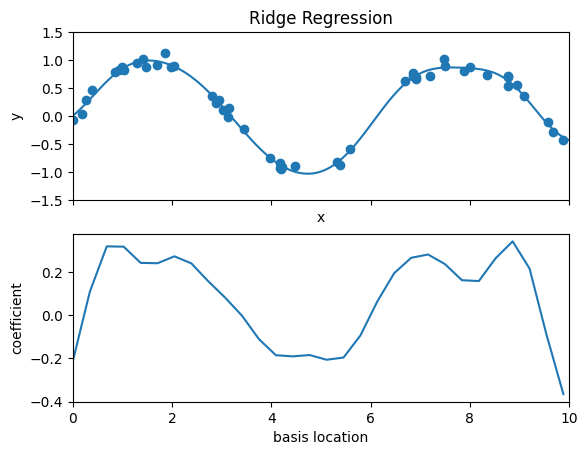

In [20]:
model = make_pipeline(GaussianFeatures(30), Ridge(alpha=0.1))
basis_plot(model, title='Ridge Regression')

The α parameter is essentially a knob controlling the complexity of the resulting model. In the limit α→0, we recover the standard linear regression result; in the limit α→∞, all model responses will be suppressed. One advantage of ridge regression in particular is that it can be computed very efficiently—at hardly more computational cost than the original linear regression model.

### Lasso Regression

This involves penalizing the sum of absolute values (1-norms) of regression coefficients:

$$ P = \alpha \sum_{n=1}^{N} |\theta_n| $$

Though this is conceptually very similar to ridge regression, the results can differ surprisingly: for example, due to geometric reasons lasso regression tends to favor sparse models where possible: that is, it preferentially sets model coefficients to exactly zero.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.136e-03, tolerance: 2.065e-03
  model = cd_fast.enet_coordinate_descent(


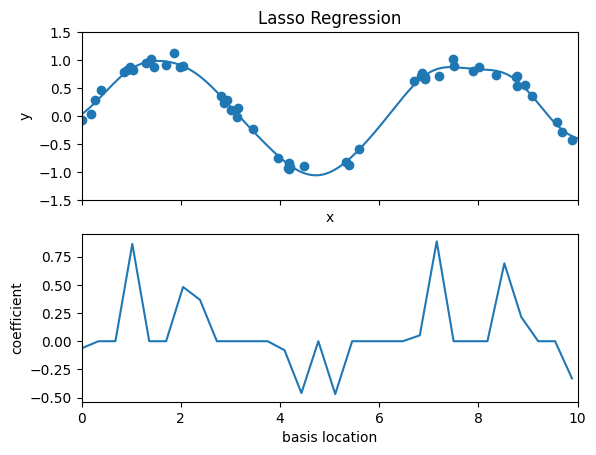

In [22]:
model = make_pipeline(GaussianFeatures(30), Lasso(alpha=0.001))
basis_plot(model, title='Lasso Regression')

With the lasso regression penalty, the majority of the coefficients are exactly zero, with the functional behavior being modeled by a small subset of the available basis functions. As with ridge regularization, the α parameter tunes the strength of the penalty, and should be determined via, for example, cross-validation.

## Predicting Bicycle Traffic

As an example, let's take a look at whether we can predict the number of bicycle trips across Seattle's Fremont Bridge based on weather, season, and other factors.

we will join the bike data with another dataset, and try to determine the extent to which weather and seasonal factors—temperature, precipitation, and daylight hours—affect the volume of bicycle traffic through this corridor.

We will perform a simple linear regression to relate weather and other information to bicycle counts, in order to estimate how a change in any one of these parameters affects the number of riders on a given day.

In particular, this is an example of how the tools of Scikit-Learn can be used in a statistical modeling framework, in which the parameters of the model are assumed to have interpretable meaning. As discussed previously, this is not a standard approach within machine learning, but such interpretation is possible for some models.

In [39]:
#!curl -o FremontBridge.csv https://data.seattle.gov/api/views/65db-xm6k/rows.csv?accessType=DOWNLOAD

Opening this excercise using Colab:

- https://colab.research.google.com/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05.06-Linear-Regression.ipynb#scrollTo=18xzdpeU94eD

Loading datasets:

In [26]:
url = 'https://raw.githubusercontent.com/jakevdp/bicycle-data/main'
!curl -O {url}/FremontBridge.csv
!curl -O {url}/SeattleWeather.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 4585k  100 4585k    0     0  5726k      0 --:--:-- --:--:-- --:--:-- 5724k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  534k  100  534k    0     0  1293k      0 --:--:-- --:--:-- --:--:-- 1290k


In [28]:
counts = pd.read_csv('FremontBridge.csv', index_col='Date', parse_dates=True)
weather = pd.read_csv('SeattleWeather.csv', index_col='DATE', parse_dates=True)

<ipython-input-28-3228a30322bd>:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  counts = pd.read_csv('FremontBridge.csv', index_col='Date', parse_dates=True)


In [33]:
# analyzing data perior covid-19 (2020) to avoid the effects of the pandemic, which affected the entire world
counts = counts[counts.index < '2020-01-01']
weather = weather[weather.index < '2020-01-01']

In [34]:
# Creating a new dataframe out of results from computing the total daily bicycle traffic
daily = counts.resample('d').sum()
daily['Total'] = daily.sum(axis=1)
daily = daily[['Total']] # removing other columns

In [35]:
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'] # adding days of the week
for i in range(7):
    daily[days[i]] = (daily.index.dayofweek == i).astype(float)

In [36]:
# We might expect riders to behave differently on holidays
# let's add an indicator of this as well:

cal = USFederalHolidayCalendar()
holidays = cal.holidays('2012', '2020')
daily = daily.join(pd.Series(1, index=holidays, name='holiday'))
daily['holiday'].fillna(0, inplace=True)

(8.0, 17.0)

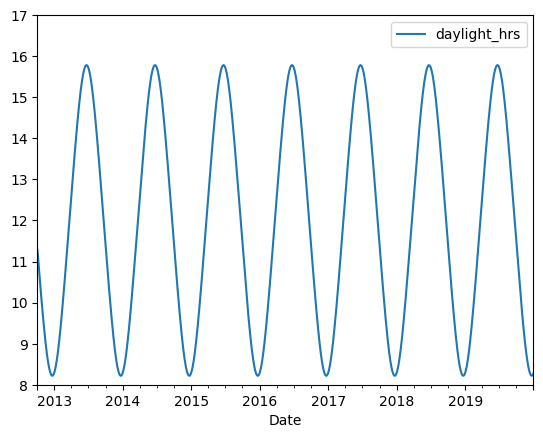

In [38]:
def hours_of_daylight(date, axis=23.44, latitude=47.61):
    """Compute the hours of daylight for the given date"""
    days = (date - pd.Timestamp(2000, 12, 21)).days # AttributeError: module 'pandas' has no attribute 'datetime' -> had to change to Timestamp
    m = (1. - np.tan(np.radians(latitude))
         * np.tan(np.radians(axis) * np.cos(days * 2 * np.pi / 365.25)))
    return 24. * np.degrees(np.arccos(1 - np.clip(m, 0, 2))) / 180.

daily['daylight_hrs'] = list(map(hours_of_daylight, daily.index))
daily[['daylight_hrs']].plot()
plt.ylim(8, 17)


We can also add the average temperature and total precipitation to the data. In addition to the inches of precipitation, let's add a flag that indicates whether a day is dry (has zero precipitation):

In [41]:
weather['Temp (F)'] = 0.5 * (weather['TMIN'] + weather['TMAX'])
weather['Rainfall (in)'] = weather['PRCP']
weather['dry day'] = (weather['PRCP'] == 0).astype(int)

daily = daily.join(weather[['Rainfall (in)', 'Temp (F)', 'dry day']])

Let's add a counter that increases from day 1, and measures how many years have passed. This will let us measure any observed annual increase or decrease in daily crossings:

In [42]:
daily['annual'] = (daily.index - daily.index[0]).days / 365.

In [43]:
daily.head()

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs,Rainfall (in),Temp (F),dry day,annual
Date,,,,,,,,,,,,,,
2012-10-03,14084.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,11.277359,0.0,56.0,1,0.000000
2012-10-04,13900.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11.219142,0.0,56.5,1,0.002740
2012-10-05,12592.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,11.161038,0.0,59.5,1,0.005479
2012-10-06,8024.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,11.103056,0.0,60.5,1,0.008219
2012-10-07,8568.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.045208,0.0,60.5,1,0.010959


Now, we can choose the columns to use and fit a linear regression model to our data.

We will set **fit_intercept = False**, because the daily flags essentially operate as their own day specific intercepts:

In [44]:
# Dropping any rows with null values
daily.dropna(axis=0, how='any', inplace=True)

In [45]:
column_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun',
                'holiday', 'daylight_hrs', 'Rainfall (in)',
                'dry day', 'Temp (F)', 'annual']
X = daily[column_names]
y = daily['Total']

model = LinearRegression(fit_intercept=False)
model.fit(X, y)
daily['predicted'] = model.predict(X)

We can now compare the total and predicted bicycle traffic visually as shown below:

<Axes: xlabel='Date'>

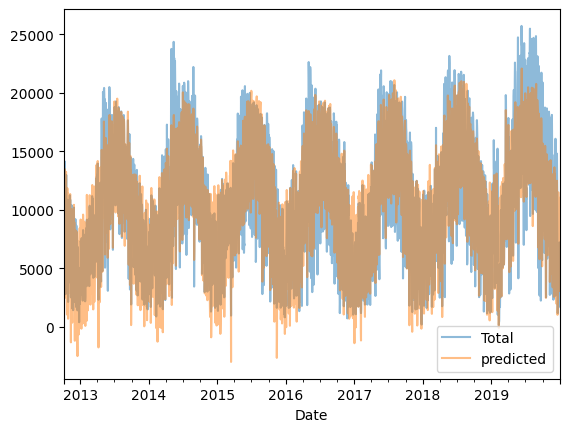

In [46]:
daily[['Total', 'predicted']].plot(alpha = 0.5)

The data and model predictions don't line up exactly, it is evident that we have missed some key features. Either our features are not complete or there are some nonlinear relationships that we have failed to take into account. Nevertheless, our rough approximation is enough to give us some insights, and we can take a look at the coefficients of the linear model to estimate how much each feature contributes to the daily bicycle count:

In [48]:
params = pd.Series(model.coef_, index=X.columns)
params

,0
Mon,-3309.953439
Tue,-2860.625060
Wed,-2962.889892
Thu,-3480.656444
Fri,-4836.064503
Sat,-10436.802843
Sun,-10795.195718
holiday,-5006.995232
daylight_hrs,409.146368
Rainfall (in),-2789.860745


In [50]:
np.random.seed(1)
err = np.std([model.fit(*resample(X, y)).coef_
              for i in range(1000)], 0)

In [51]:
print(pd.DataFrame({'effect': params.round(0), 'uncertainty': err.round(0)}))

                effect  uncertainty
Mon            -3310.0        265.0
Tue            -2861.0        274.0
Wed            -2963.0        268.0
Thu            -3481.0        268.0
Fri            -4836.0        261.0
Sat           -10437.0        259.0
Sun           -10795.0        267.0
holiday        -5007.0        401.0
daylight_hrs     409.0         26.0
Rainfall (in)  -2790.0        186.0
dry day         2111.0        101.0
Temp (F)         179.0          7.0
annual           324.0         22.0


The effect column here shows how the number of riders is affected by a change of the feature in question. For example, there is a clear divide when it comes to the day of the week: there are thousands fewer riders on weekends than on weekdays.

We also see that for each additional hour of daylight, 409 ± 26 more people choose to ride, a temperature increase of one degree Fahrenheit encourages 179 ± 7 people to grab their bicycle, a dry day means an average of 2,111 ± 101 more riders, and every inch of rainfall leads 2,790 ± 186 riders to choose another mode of transport.

Once all these effects are accounted for, we see a modest increase of 324 ± 22 new daily riders each year.

# Part 2 - Statsmodels

## Ordinary Linear Square

OLS is basically the method used to find the best fitting line or relationship between two variables. This model from Stats model will find the best line that best describes the relationship between income and education.

In [53]:
import statsmodels.api as sm

In [54]:
duncan_prestige = sm.datasets.get_rdataset('Duncan', 'carData')
Y = duncan_prestige.data['income']
X = duncan_prestige.data['education']
X = sm.add_constant(X)
model = sm.OLS(Y,X)
results = model.fit()
results.params

,0
const,10.603498
education,0.594859


## Generalized Linear Model

GLM will help to model different types of relationships bbetween variables. Also, it can help us work with other types of outcomes such as binary outputs (Logistic Regression).

In [63]:
#data = sm.datasets.scotland.load(as_pandas=False)
# had to change because it seemed deprecated
data = sm.datasets.scotland.load()
data.exog = sm.add_constant(data.exog)

# instantiate a gamma family model with the default link function
gamma_model = sm.GLM(data.endog, data.exog, family=sm.families.Gamma())
gamma_results = gamma_model.fit()
print(gamma_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                    YES   No. Observations:                   32
Model:                            GLM   Df Residuals:                       24
Model Family:                   Gamma   Df Model:                            7
Link Function:           InversePower   Scale:                       0.0035843
Method:                          IRLS   Log-Likelihood:                -83.017
Date:                Sun, 22 Sep 2024   Deviance:                     0.087389
Time:                        19:57:47   Pearson chi2:                   0.0860
No. Iterations:                     6   Pseudo R-squ. (CS):             0.9800
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.0178      0

## Logistic (Logit)

- This is just logistic regression using Statsmodel.

In [57]:
spector_data = sm.datasets.spector.load_pandas()
spector_data.exog = sm.add_constant(spector_data.exog)


# Logit Model
logit_mod = sm.Logit(spector_data.endog, spector_data.exog)
logit_res = logit_mod.fit()
print(logit_res.summary())

Optimization terminated successfully.
         Current function value: 0.402801
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                  GRADE   No. Observations:                   32
Model:                          Logit   Df Residuals:                       28
Method:                           MLE   Df Model:                            3
Date:                Sun, 22 Sep 2024   Pseudo R-squ.:                  0.3740
Time:                        19:53:26   Log-Likelihood:                -12.890
converged:                       True   LL-Null:                       -20.592
Covariance Type:            nonrobust   LLR p-value:                  0.001502
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -13.0213      4.931     -2.641      0.008     -22.687      -3.356
GPA            2.8261      1.

I will definetly explore Statsmodel more because I htink it can easily describe the information I need to make good predictions. I've never used it before, but I'm looking forward to it!

# Sources:

- Markdown Colab: https://colab.research.google.com/notebooks/markdown_guide.ipynb

- linear regression: https://www.geeksforgeeks.org/linear-regression-python-implementation/

- Slope: https://www.andrews.edu/~calkins/math/edrm611/edrm06.htm#:~:text=If%20the%20slope%20is%20negative,due%20to%20division%20by%20zero.


- Basis functions ans Vectorization: https://courses.cs.washington.edu/courses/cse446/20wi/Lecture7/07_BasisFunctions.pdf

- https://www.youtube.com/watch?v=xTo8Q9asVfc

- pipeline vs make_pipeline: https://www.geeksforgeeks.org/what-is-the-difference-between-pipeline-and-make_pipeline-in-scikit/

- overfitting vs underfitting: https://www.geeksforgeeks.org/underfitting-and-overfitting-in-machine-learning/

- ridge vs lasso: https://www.analyticsvidhya.com/blog/2016/01/ridge-lasso-regression-python-complete-tutorial/

- Colab notebook: https://colab.research.google.com/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05.06-Linear-Regression.ipynb#scrollTo=18xzdpeU94eD

- timestamp - pandas: https://pandas.pydata.org/pandas-docs/version/0.17.1/timeseries.html

- Stats model basics: https://www.statsmodels.org/stable/gettingstarted.html

- Stats model: https://www.geeksforgeeks.org/linear-regression-in-python-using-statsmodels/

- Stats Model - OLS: https://www.geeksforgeeks.org/ordinary-least-squares-ols-using-statsmodels/

- OLS: https://www.statsmodels.org/stable/examples/notebooks/generated/ols.html

- GLM: https://www.statsmodels.org/stable/generated/statsmodels.genmod.generalized_linear_model.GLM.html

- GLM: https://medium.com/@sssspppp/generalized-linear-model-f607ac7f0ef5

- Logistic Regression using Statsmodel: https://www.geeksforgeeks.org/logistic-regression-using-statsmodels/




